In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import HGate, CXGate, QFT
from qiskit.circuit import Parameter, ParameterVector, Barrier
from qiskit.circuit import Gate

from qiskit_algorithms.minimum_eigensolvers.vqe import VQE
from qiskit_algorithms.optimizers import SPSA, COBYLA

from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.quantum_info import SparsePauliOp

import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations

In [7]:
num_q_site=3

# qc_total=QuantumCircuit(num_q_orbital+num_q_site)
# qc_orbital=QuantumCircuit(num_q_orbital) # orbital register
# qc_site=QuantumCircuit(num_q_site) # site register
# qc_p=QuantumCircuit(num_q_site) # minimum unit for representing quantum number p
# qc_QFT=QuantumCircuit(num_q_site) # quantum circuit for executing quantum fourier transform

optimizer = COBYLA()

In [8]:
#################
# Site register #
#################

def decimal_to_binary(num_q_site, p):
    bin_array=list()
    denominator=p
    for i in reversed(range(num_q_site)):
        bit=denominator//(2**i)
        bin_array.append(bit)
        denominator=denominator-bit*(2**i)
    return bin_array

def QuantumFourierTransform(num_q_site):
    qc_QFT=QuantumCircuit(num_q_site, name='QFT')
    
    # Before SWAP
    for i in range(num_q_site):        
        qc_QFT.h(i)
        for j in range(num_q_site-1-i):
            theta=(2*np.pi)/(2**(j+2))
            qc_QFT.crz(theta=theta , control_qubit=j+1+i , target_qubit=i)
        qc_QFT.barrier()
    
    # after SWAP
    for i in range(num_q_site//2):
        qc_QFT.swap(i, num_q_site-1-i)
    
    return qc_QFT

def ansatze_site(num_q_site, p):
    bin_array=decimal_to_binary(num_q_site, p)
    qc_ansatze_site = QuantumCircuit(num_q_site, name=f'site_register[p={p}]')
    
    for i, bit in enumerate(bin_array):
        if bit==1:
            qc_ansatze_site.x(i)
    qc_ansatze_site.barrier()
    
    qc_tmp=QuantumFourierTransform(num_q_site)
    inst=qc_tmp.to_instruction()
    qc_ansatze_site.append(inst, range(num_q_site))
    
    # qc_ansatze_site.append(QFT(num_q_site, name=f'QFT[p={p}]'), range(num_q_site))
    
    return qc_ansatze_site

In [9]:
############################################
# Useful functions for Hamiltonian mapping #
############################################

def list_to_str(list_data):
    str_first = ''
    for str_data in list_data:
        str_first += str_data
    return str_first

def get_binary_str_desired_ones(n, k):
    result = []
    for ones_positions in combinations(range(n), k):
        binary_str = [0] * n
        for position in ones_positions:
            binary_str[position] = 1
        result.append(binary_str)
    return result

In [10]:
#####################################
# Hamiltonian Implementation - Site #
#####################################

def A_r(r):
    A_r_string=[]
    coeff=[]
    for k in range((r//2)+1):
        str_desired_ones=get_binary_str_desired_ones(r, 2*k)
        for l in str_desired_ones:
            raw_string=['X']*r
            for idx, bin in enumerate(l):
                if bin==True: 
                    raw_string[idx]='Y'
            if k%2==1: coeff.append(-1)
            else: coeff.append(1)
            tmp=list_to_str(raw_string)
            A_r_string.append(tmp)
    tmp=np.array(coeff)
    coeff=tmp/(2**r)
    return SparsePauliOp(data=A_r_string, coeffs=coeff)

def B_r(r):
    B_r_string=[]
    coeff=[]
    for k in range((r//2)+1):
        if r==0: str_desired_ones=[[]]
        else: str_desired_ones=get_binary_str_desired_ones(r, 2*k+1)
        for l in str_desired_ones:
            raw_string=['X']*r
            for idx, bin in enumerate(l):
                if bin==True:
                    raw_string[idx]='Y'
                    
            if k%2==0: coeff.append(-1)
            else: coeff.append(1)
            
            tmp=list_to_str(raw_string)
            B_r_string.append(tmp)
    tmp=np.array(coeff)
    coeff=tmp/(2**r)
    return SparsePauliOp(data=B_r_string, coeffs=coeff) 

def custom_sparsepauliop(input_sparsepauliop, X_boolean, Y_boolean, coeff_multiply):
    if X_boolean==True: add_string='X'
    if Y_boolean==True: add_string='Y'
    if X_boolean==False and Y_boolean==False: add_string=''
    
    paulis_input=input_sparsepauliop.paulis
    coeffs_input=input_sparsepauliop.coeffs
    
    tmp_paulis=paulis_input.to_labels()
    for i in range(len(tmp_paulis)):
        tmp_paulis[i]=add_string+tmp_paulis[i]
    paulis_output=tmp_paulis
    
    coeffs_output=coeff_multiply*coeffs_input
    
    return SparsePauliOp(data=paulis_output, coeffs=coeffs_output)      

def custom_I(input_sparsepauliop, r):
    # add_string='I'*(num_q_orbital+num_q_site-r-1)
    add_string='I'*(num_q_site-r-1)
    paulis_custom=input_sparsepauliop.paulis
    coeffs_constant=input_sparsepauliop.coeffs
    
    tmp_paulis=paulis_custom.to_labels()
    for i in range(len(tmp_paulis)):
        tmp_paulis[i]=add_string+tmp_paulis[i]
    paulis_output=tmp_paulis
        
    return SparsePauliOp(data=paulis_output, coeffs=coeffs_constant)

def get_A_N():
    sum_list=[]
    
    A_n=custom_I(A_r(num_q_site), r=num_q_site-1)
    sum_list.append(A_n)
    
    for i in range(num_q_site):
        if i==0:
            tmp_A_0=custom_I(custom_sparsepauliop(A_r(i), X_boolean=True, Y_boolean=False, coeff_multiply=0.5), r=i)
            sum_list.append(tmp_A_0)
            tmp_B_0=custom_I(custom_sparsepauliop(A_r(i), X_boolean=False, Y_boolean=True, coeff_multiply=-0.5), r=i)
            sum_list.append(tmp_B_0)
        else:
            tmp_A=custom_I(custom_sparsepauliop(A_r(i), X_boolean=True, Y_boolean=False, coeff_multiply=0.5), r=i)
            sum_list.append(tmp_A)
            tmp_B=custom_I(custom_sparsepauliop(B_r(i), X_boolean=False, Y_boolean=True, coeff_multiply=-0.5), r=i)
            sum_list.append(tmp_B)
    
    A_N=sum(sum_list)    
    return A_N

def get_B_N():
    sum_list=[]
    
    B_n=custom_I(B_r(num_q_site), r=num_q_site-1)
    sum_list.append(B_n)
    
    for i in range(num_q_site):
        if i==0:
            tmp_B_0=custom_I(custom_sparsepauliop(B_r(i), X_boolean=False, Y_boolean=True, coeff_multiply=-0.5), r=i)
            sum_list.append(tmp_B_0)
            tmp_A_0=custom_I(custom_sparsepauliop(A_r(i), X_boolean=True, Y_boolean=False, coeff_multiply=0.5), r=i)
            sum_list.append(tmp_A_0)
        else:
            tmp_A=custom_I(custom_sparsepauliop(A_r(i), X_boolean=False, Y_boolean=True, coeff_multiply=0.5), r=i)
            sum_list.append(tmp_A)
            tmp_B=custom_I(custom_sparsepauliop(B_r(i), X_boolean=True, Y_boolean=False, coeff_multiply=0.5), r=i)
            sum_list.append(tmp_B)
    
    B_N=sum(sum_list)    
    return B_N  


def get_I_N():
    I_string=[]
    raw_I_string=['I']*num_q_site
    tmp=list_to_str(raw_I_string)
    I_string.append(tmp)
    return SparsePauliOp(data=I_string)

get_I_N()  

# get_B_N()

# print(A_r(5).paulis)
# print(A_r(5).coeffs)

# a=B_r(3).paulis
# b=B_r(3).coeffs
# b_new=b*(-1)
# SparsePauliOp(a, b_new)

SparsePauliOp(['III'],
              coeffs=[1.+0.j])

In [11]:
############################
# Hamiltonian construction #
############################

def Hamiltonian(t_0, t_1):
    I_N=get_I_N()
    A_N=get_A_N()
    B_N=get_B_N()
    
    return I_N, A_N, B_N

In [65]:
def vqe(num_q_site, energy_level, previous_params_list, t_0, t_1):
    # divide quantum circuit into orbital register part and site register part each
    circuit_divider={'orbital':[], 'site':[]}
    for i in range(num_q_orbital+num_q_site):   
        if i<num_q_orbital:
            circuit_divider['orbital'].append(i)
        else:
            circuit_divider['site'].append(i)
    
    if previous_params_list==None: # target energy level is 0th : ground state band
                
        # parameter list : 2 dimensional list [columns : parameter for each parametric gate, rows : p's(0,1,...,2**n-1)]
        params_fixed_0th=list()
        
        # eigen energy list : 1 dimensional list [row : eigen energy for sequential p's(0,1,...,2**n-1)]
        eigen_energy_0th=list()
        
        # entire ansatze for 0th level and optimization with the for loop containing site ansatze and its corresponding quantum number p
        for p in range(2**num_q_site):
            qc_0th=QuantumCircuit(num_q_orbital+num_q_site, name='ansatze_0th_level')
        
            # orbital ansatze for 0th level
            qc_orbital_0th=ansatze_orbital_encoding(energy_level) # orbital encoding for 0th energy level
            num_params=2*(num_q_orbital-energy_level-1)
            params_0th=ParameterVector("θ", num_params)
            qc_tmp=ansatze_level(energy_level, params_level=params_0th)
            inst=qc_tmp.to_instruction()
            qc_orbital_0th.append(inst, range(num_q_orbital))
            
            # site ansatze for 0th level
            qc_site_0th=ansatze_site(num_q_site, p)
            
            # construct entire ansatze
            inst_orbital=qc_orbital_0th.to_instruction()
            inst_site=qc_site_0th.to_instruction()
            qc_0th.append(inst_orbital, circuit_divider['orbital'])
            qc_0th.append(inst_site, circuit_divider['site'])
        
            def loss(x):
                estimator = Estimator()
                pub = (qc_0th, Hamiltonian(t_0, t_1), x)
                job = estimator.run([pub])
                result = job.result()[0]
                return np.sum(result.data.evs)

            result = optimizer.minimize(loss, x0 = [0.2]*qc_0th.num_parameters)
            print(f'0th eigen energy information (p={p}) : {result}')
            params_fixed_0th.append(result.x)
            eigen_energy_0th.append(result.fun)
        
        return qc_orbital_0th, params_fixed_0th, eigen_energy_0th
    
    else: # set ansatze for nonzero energy level 
                
        # parameter list : 2 dimensional list [columns : parameter for each parametric gate, rows : p's(0,1,...,2**n-1)]
        params_fixed_ith=list()
        
        # eigen energy list : 1 dimensional list [row : eigen energy for sequential p's(0,1,...,2**n-1)]
        eigen_energy_ith=list()
        
        # entire ansatze for ith level with other fixed ansatze's and optimization with the for loop containing site ansatze and its corresponding quantum number p
        for p in range(2**num_q_site-1):
            qc_ith=QuantumCircuit(num_q_orbital+num_q_site, name=f'ansatze_{i}th_level')
            
            # current energy level
            qc_orbital_ith=ansatze_orbital_encoding(energy_level)    
            num_params=2*(num_q_orbital-energy_level-1)
            params=ParameterVector("θ", num_params)
            qc_tmp=ansatze_level(energy_level, params_level=params)
            inst_current=qc_tmp.to_instruction()
            qc_orbital_ith.append(inst_current, range(num_q_orbital))
            
            # previous energy level with fixed parameters
            for i in reversed(range(energy_level)):
                qc_orbital_ith.barrier()
                params=previous_params_list[i][p]
                previous_level_qc=ansatze_level(energy_level=i, params_level=params)
                inst=previous_level_qc.to_instruction()
                qc_orbital_ith.append(inst, range(num_q_orbital))
                
            # site ansatze for ith level
            qc_site_ith=ansatze_site(num_q_site, p)
            
            # construct entire ansatze
            inst_orbital=qc_orbital_ith.to_instruction()
            inst_site=qc_site_ith.to_instruction()
            qc_ith.append(inst_orbital, circuit_divider['orbital'])
            qc_ith.append(inst_site, circuit_divider['site'])
            
            def loss(x):
                estimator = Estimator()
                pub = (qc_ith, Hamiltonian(t_0, t_1), x)
                job = estimator.run([pub])
                result = job.result()[0]
                return np.sum(result.data.evs)

            result = optimizer.minimize(loss, x0 = [0.2]*qc_ith.num_parameters)
            print(f'{energy_level}th eigen energy information (p={p}) : {result}')
            params_fixed_ith.append(result.x) # further obtained
            eigen_energy_ith.append(result.fun)
        
        return qc_orbital_ith, params_fixed_ith, eigen_energy_ith

In [66]:
upper_bound_level=0
params_library = dict()
eigen_energy_library = dict()
t_0=[[-0.5,1],
     [1,0.5]]
t_1=[[0, 0],
     [1, 0]]
# t_1=np.ones((num_q_orbital,num_q_orbital)).tolist()


for i in range(upper_bound_level+1):
    if i==0:
        _ , params_fixed_0th, eigen_energy_0th = vqe(
            num_q_orbital=num_q_orbital,
            num_q_site=num_q_site,
            energy_level=i, 
            previous_params_list=None,
            t_0=t_0,
            t_1=t_1
        )
        params_library['level_'+str(i)] = params_fixed_0th
        eigen_energy_library['level_'+str(i)]=eigen_energy_0th
    else:
        params_send = [params_library['level_'+str(j)] for j in range(i)]
        _ , params_fixed_ith, eigen_energy_ith = vqe(
            num_q_orbital=num_q_orbital,
            num_q_site=num_q_site,
            energy_level=i, 
            previous_params_list=params_send,
            t_0=t_0,
            t_1=t_1
        )
        params_library['level_'+str(i)] = params_fixed_ith
        eigen_energy_library['level_'+str(i)]=eigen_energy_ith

0th eigen energy information (p=0) : {   'fun': -0.7499999977779945,
    'jac': None,
    'nfev': 40,
    'nit': None,
    'njev': None,
    'x': array([7.85347918e-01, 8.76230029e-05])}
0th eigen energy information (p=1) : {   'fun': -0.7403926372259024,
    'jac': None,
    'nfev': 40,
    'nit': None,
    'njev': None,
    'x': array([ 0.78545703, -0.19624983])}
0th eigen energy information (p=2) : {   'fun': -0.7119397627105852,
    'jac': None,
    'nfev': 46,
    'nit': None,
    'njev': None,
    'x': array([ 0.7854725, -0.3927782])}
0th eigen energy information (p=3) : {   'fun': -0.6657348023856885,
    'jac': None,
    'nfev': 37,
    'nit': None,
    'njev': None,
    'x': array([ 0.78548409, -0.58907289])}
0th eigen energy information (p=4) : {   'fun': -0.6035533884246195,
    'jac': None,
    'nfev': 48,
    'nit': None,
    'njev': None,
    'x': array([ 0.78533417, -0.78542927])}
0th eigen energy information (p=5) : {   'fun': -0.5277851149195485,
    'jac': None,
    '

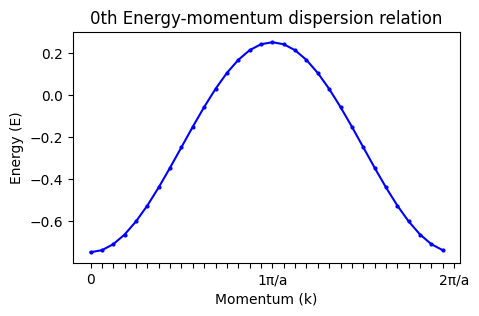

In [69]:
x=np.array(range(2**num_q_site))*(2*np.pi)/(2**num_q_site)
y=eigen_energy_library['level_0']

plt.figure(figsize=(5, 3))
plt.plot(x, y, 'bo-', markersize=2)

x_axis=x.tolist()
x_axis.append(2*np.pi)

x_label=list()
for i in x_axis:
    if (i%(np.pi))==0:
        if i==0: x_label.append('0')
        else : x_label.append(f'{int(i//np.pi)}π/a')
    else:
        x_label.append('')


plt.xticks(x_axis, labels=x_label)
plt.xlabel('Momentum (k)')
plt.ylabel('Energy (E)')
plt.title('0th Energy-momentum dispersion relation')
plt.show()